# Attention as a Ranking model from scratch

# 11-2025: Using Attention Block MLP in database systems

### **Objective**
The goal is to design a lightweight "head" that acts as a gatekeeper for a temporary knowledge base situated between a vector database and large language models. One alternative approach could involve a Hopfield Network (Hebbian Learning algorithm) to temporarily store or memorize information. When combined with models like Hidden Markov Models or graph-based methods (e.g., Google PageRank), this could enable a dynamic and interpretable ranking system.

### **Application Plan**

Imagine a simple case: retaining meaningful information from a chat session between a user and a bot. Let’s assume only the following components matter:

- Base Model: A large language model serving as the core engine behind the bot’s responses.
- Session Cache: A cache or lightweight memory system responsible for computing and managing key-value pairs (KV-cache) and attention outputs that guide the model’s behavior during the session.
- Datastore: A memory or retrieval-augmented generation (RAG) system that stores the bot’s persistent "identity"—such as its biography, profile, or long-term observations.

The objective is to build meaningful connections—or "passages"—between these components to support the full data lifecycle, from short-term interactions to long-term memory. For example: (Datastore + Session Cache) → Base Model: The combination of cached attention values and conditioning embeddings from the datastore can be reranked or reweighted to guide the model in generating more coherent and personalized responses in the next turn of dialogue.



## Warnings for future self / reader 
- The results may be biased to the synthetic dataset. 

## Notes on applying different loss functions

- `nn.BCEWithLogitsLoss`: according to pytorch docs, this loss function expects log scores (no activations) 
    - Despite the target was to design a ranking model head 



In [1]:
import warnings
import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification

warnings.filterwarnings("ignore", category=UserWarning, message="To copy construct from a tensor")

def plot_train_loss(train_losses, title='Training Loss over epochs (1 batch / epoch)', ylabel='Loss', xlabel='Epoch'):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

torch.Size([10, 3, 25, 50])
torch.Size([10, 25, 50])
Model predicted ranks:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) Number of correct 2 target: tensor([4, 4, 0, 2, 1, 1, 2, 3, 0, 3])
Epoch 1/100 - Loss: 0.2580
Model predicted ranks:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) Number of correct 2 target: tensor([4, 4, 0, 2, 1, 1, 2, 3, 0, 3])
Epoch 2/100 - Loss: 0.2541
Model predicted ranks:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) Number of correct 2 target: tensor([4, 4, 0, 2, 1, 1, 2, 3, 0, 3])
Epoch 3/100 - Loss: 0.2498
Model predicted ranks:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) Number of correct 2 target: tensor([4, 4, 0, 2, 1, 1, 2, 3, 0, 3])
Epoch 4/100 - Loss: 0.2461
Model predicted ranks:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) Number of correct 2 target: tensor([4, 4, 0, 2, 1, 1, 2, 3, 0, 3])
Epoch 5/100 - Loss: 0.2428
Model predicted ranks:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) Number of correct 2 target: tensor([4, 4, 0, 2, 1, 1, 2, 3, 0, 3])
Epoch 6/100 - Loss: 0.2389
Model

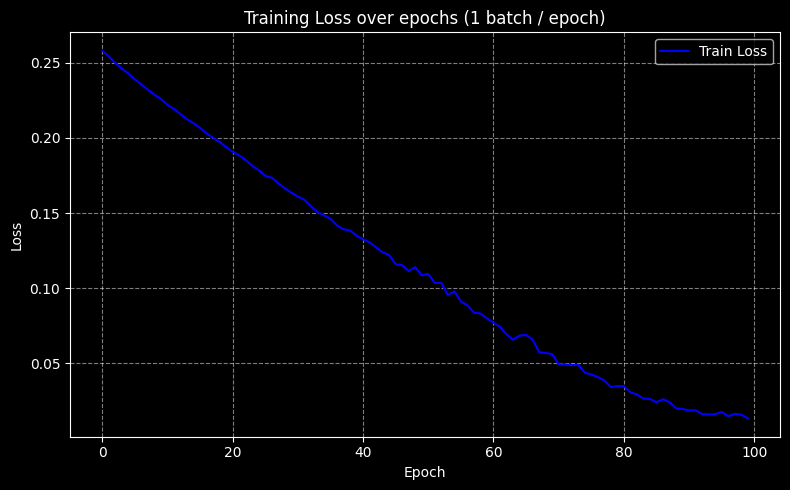

In [ ]:
def create_ordinal_target(num, length: int) -> torch.Tensor:
    """
    Converts a list of integer ranks into binary target vectors, where each vector contains 1s from index 0 to `num[i] - 1`
    and 0s for the rest, based on a fixed vector length.

    Args:
        num (list): A list of integers specifying how many 1s each vector should contain.
        length (int): The total length of each output vector (or the number of ranking placements)

    Returns:
        torch.Tensor: A tensor of shape (len(num), length) with 1s up to each corresponding
                      value in `num`, and 0s elsewhere.

    Example:
        >>> create_target([2, 4], 5)
        tensor([[1, 1, 0, 0, 0],
                [1, 1, 1, 1, 0]])
    """
    assert not isinstance(num, int), f"Num must be either tensor / numpy list."
    num_data = len(num)
    vec = torch.zeros((num_data, length), dtype=torch.float, requires_grad=False)
    for idx, d in enumerate(num):
        vec[idx, :d] = 1.0
    return vec


class Ranker(nn.Module):
    def __init__(self, num_ranks, emb_dim, num_heads, dropout_rate=0.6, seq_len=25):
        super(Ranker, self).__init__()
        self.num_ranks = num_ranks
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.seq_len = seq_len

        # batch_first means that input and output follows (1, seq_length, emb_dim)
        self.attn = nn.MultiheadAttention(
            self.emb_dim,
            self.num_heads,
            dropout=self.dropout_rate,
            batch_first=True,
            bias=False,
        )
        self.fn = nn.Linear(self.emb_dim, self.num_ranks, bias=True)

    def forward(self, Q, K, V):
        assert Q.size(1) == self.seq_len and Q.size(2) == self.emb_dim, (
            f"Expected Q shape [batch_size, {self.seq_len}, {self.emb_dim}](batch_size, seq_len, emb_dim) but received: {Q.shape}"
        )
        assert Q.shape == K.shape == V.shape

        batch_size = Q.size(0)
        attn_output, attn_weights = self.attn(Q, K, V)
        assert (
            attn_output.size(0) == batch_size
            and attn_output.size(1) == self.seq_len
            and attn_output.size(2) == self.emb_dim
        ), (
            f"Expected Attn output shape to be (batch_size {self.seq_len}, {self.emb_dim}) but received {attn_output.shape}"
        )
        assert (
            attn_weights.size(0) == batch_size
            and attn_weights.size(1) == attn_weights.size(2) == self.seq_len
        ), (
            f"Expected Attn output weight shape to be (batch_size {self.seq_len}, {self.seq_len}) but received {attn_weights.shape}"
        )

        output = attn_output.softmax(-1)
        x = self.fn(output)
        assert (
            x.dim() == 3 and x.size(1) == self.seq_len and x.size(2) == self.num_ranks
        )
        x = x.sum(axis=1).unsqueeze(1)
        assert x.dim() == 3 and x.size(0) == batch_size and x.size(2) == self.num_ranks

        # print(f"Prediction:\n", torch.round(x * 1e2) / 1e2)
        return x.sigmoid()


def display_results(model_output, target, threshold: float = 0.65):
    """counts by batch input higher than threshold"""
    results = (model_output > threshold).sum(axis=-1)
    target_results = (target > threshold).sum(axis=-1)
    print(
        "Model predicted ranks: ",
        results.flatten(),
        "Number of correct",
        (results.flatten() == target_results.flatten()).sum(axis=0).item(),
        "target:",
        target_results.flatten(),
    )

def formally_mock_data(batch_size, num_ranks, emb_dim, seq_len):
    # mock dataset generation args
    X, y = make_classification(
        n_samples=batch_size,
        n_features=emb_dim * seq_len * 3,
        n_informative=num_ranks,
        n_redundant=1,
        n_classes=num_ranks,
        class_sep=1.0,
        random_state=42,
    )

    X_grouped = torch.tensor(X, dtype=torch.float).view(batch_size, 3, seq_len, emb_dim)
    print(X_grouped.shape)
    q = torch.tensor(X_grouped[:, 0, :, :]).clone().detach()
    k = torch.tensor(X_grouped[:, 1, :, :]).clone().detach()
    v = torch.tensor(X_grouped[:, 2, :, :]).clone().detach()
    print(q.shape)
    target = create_ordinal_target(y, length=num_ranks)
    target = target.unsqueeze(1)
    return q, k, v, target

def trial(max_epoch: int = 100):
    train_loss = []
    emb_dim = 50
    num_heads = 2
    dropout_rate = 0.6
    num_ranks = 5
    seq_len = 25
    batch_size = 10

    q, k, v, target = formally_mock_data(
        batch_size=batch_size, num_ranks=num_ranks, emb_dim=emb_dim, seq_len=seq_len
    )
    model = Ranker(num_ranks, emb_dim, num_heads, dropout_rate, seq_len)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(int(max_epoch)):
        optimizer.zero_grad()

        # Assuming model(q, k, v) returns predictions of shape (batch_size, seq_len, 1)
        output = model(q, k, v)
        loss = criterion(output, target)
        display_results(output, target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        print(f"Epoch {epoch + 1}/{max_epoch} - Loss: {loss.item():.4f}")

    print(f"Final Prediction:\n", torch.round(output * 1e2) / 1e2)
    train_loss = np.array(train_loss)
    plot_train_loss(train_loss)

# qkv shape [batch_size, seq_len, emb_dim]
trial()